In [ ]:
!pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## 1. Setup & Imports

In [ ]:
# 1. Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    brier_score_loss, classification_report
)
from sklearn.calibration import calibration_curve

import shap
import warnings
warnings.filterwarnings("ignore")


## 2. Load Dataset

In [37]:
# 2. Load datasets
patients = pd.read_csv("/content/drive/MyDrive/Workshops/HackWell/dataset/patients.csv")
timeseries = pd.read_csv("/content/drive/MyDrive/Workshops/HackWell/dataset/timeseries.csv")

print("Patients shape:", patients.shape)
print("Timeseries shape:", timeseries.shape)

print("\nPatients preview:")
display(patients.head())

print("\nTimeseries preview:")
display(timeseries.head())


Patients shape: (500, 9)
Timeseries shape: (52888, 16)

Patients preview:


,patient_id,disease,age,gender,smoking,activity,sleep_hours,bmi,risk_label
0,1,Diabetes,68,M,1,7,5.3,29.9,0
1,2,Heart Failure,66,M,0,9,4.9,31.6,1
2,3,Obesity,32,M,0,8,4.9,34.8,0
3,4,Diabetes,77,M,1,4,6.5,28.5,0
4,5,COPD,62,F,0,3,8.2,33.3,0



Timeseries preview:


,patient_id,day,date,disease,systolic_bp,diastolic_bp,heart_rate,weight,glucose,hba1c,ejection_fraction,bmi,spo2,resp_rate,creatinine,egfr
0,1,1,2024-01-01,Diabetes,135,70,75,73.1,130.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2024-01-02,Diabetes,123,74,73,77.7,122.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2024-01-03,Diabetes,132,79,86,73.7,125.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2024-01-04,Diabetes,158,59,86,84.4,119.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,2024-01-05,Diabetes,146,83,71,61.1,136.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Preprocessing

In [49]:
# 3. Preprocessing

# Define the time-series columns to aggregate
ts_cols_to_aggregate = [
    "systolic_bp", "diastolic_bp", "heart_rate", "weight", "glucose",
    "hba1c", "ejection_fraction", "bmi", "spo2", "resp_rate",
    "creatinine", "egfr"
]

# Define aggregation functions
agg_funcs = ["mean", "median", "std", lambda x: x.max() - x.min()]
agg_funcs_names = ["mean", "median", "std", "range"]

# Group by patient_id and aggregate
ts_agg = timeseries.groupby("patient_id")[ts_cols_to_aggregate].agg(agg_funcs)

# Flatten the multi-level column index
ts_agg.columns = ['_'.join(col).strip() for col in ts_agg.columns.values]

# Merge with the patients DataFrame
patients_with_ts = patients.merge(ts_agg, on="patient_id", how="left")

# Drop non-numeric identifiers and the target variable from the merged dataframe
X = patients_with_ts.drop(columns=["patient_id", "disease", "risk_label"])

# Handle categorical features using one-hot encoding
X = pd.get_dummies(X, columns=["gender"], drop_first=True)

# Identify numeric columns after one-hot encoding
numeric_cols = X.select_dtypes(include=np.number).columns

# Replace NaNs with median for numeric columns only
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Target
y = patients_with_ts["risk_label"] # Use risk_label from the merged dataframe

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalize features
scaler = StandardScaler()
# Select only numeric columns for scaling
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

## 4. Train Model (Gradient Boosting with Feature Engineering)

In [39]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc', # Using AUROC as the scoring metric
    cv=cv,
    n_jobs=-1, # Use all available cores
    verbose=2
)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model for predictions
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation AUROC score: ", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best hyperparameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validation AUROC score:  0.988608776844071


## 5. Evaluation

In [40]:
# Per-Disease Evaluation

results = []

for disease in patients_with_ts["disease"].unique(): # Use patients_with_ts
    # Subset patients of this disease from the test set
    test_ids = X_test.index
    mask = (patients_with_ts.loc[test_ids, "disease"] == disease) # Use patients_with_ts

    if mask.sum() == 0:
        continue  # skip if no test patients for this disease

    # True labels & predictions
    y_true_dis = y_test[mask]
    y_pred_dis = y_pred[mask]
    y_prob_dis = y_prob[mask]

    # Metrics
    acc = accuracy_score(y_true_dis, y_pred_dis)
    prec = precision_score(y_true_dis, y_pred_dis, zero_division=0)
    rec = recall_score(y_true_dis, y_pred_dis, zero_division=0)
    f1 = f1_score(y_true_dis, y_pred_dis, zero_division=0)
    auroc = roc_auc_score(y_true_dis, y_prob_dis) if len(np.unique(y_true_dis)) > 1 else np.nan
    auprc = average_precision_score(y_true_dis, y_prob_dis) if len(np.unique(y_true_dis)) > 1 else np.nan

    results.append({
        "Disease": disease,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-score": round(f1, 3),
        "AUROC": round(auroc, 3) if not np.isnan(auroc) else "NA",
        "AUPRC": round(auprc, 3) if not np.isnan(auprc) else "NA"
    })

results_df = pd.DataFrame(results)
print("=== Per-Disease Evaluation Metrics (with Time-Series Features & Tuned Model) ===")
display(results_df)

=== Per-Disease Evaluation Metrics (with Time-Series Features & Tuned Model) ===


,Disease,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Diabetes,0.929,0.667,1.0,0.800,1.0,1.0
1,Heart Failure,0.950,1.000,0.9,0.947,1.0,1.0
2,Obesity,1.000,1.000,1.0,1.000,1.0,1.0
3,COPD,1.000,0.000,0.0,0.000,NA,NA
4,CKD,1.000,1.000,1.0,1.000,1.0,1.0


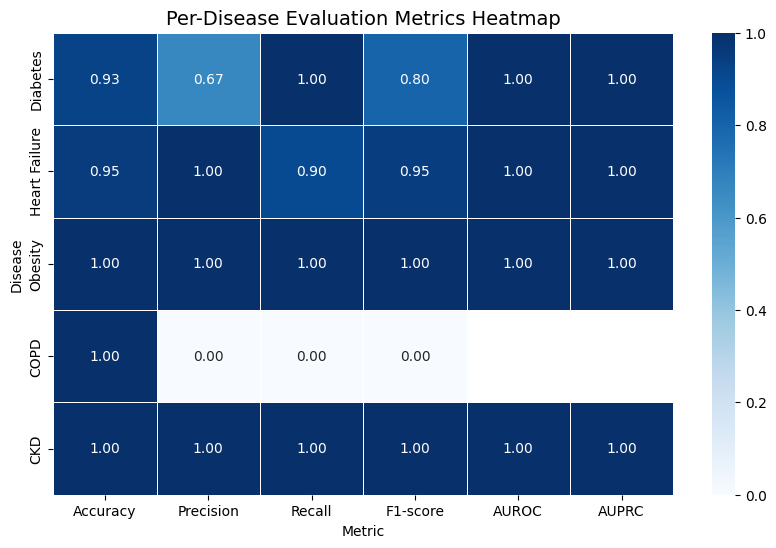

In [41]:
# Per-Disease Metrics Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results_df to numeric (replace "NA" with np.nan)
results_heatmap = results_df.copy()
for col in ["Accuracy", "Precision", "Recall", "F1-score", "AUROC", "AUPRC"]:
    results_heatmap[col] = pd.to_numeric(results_heatmap[col], errors="coerce")

plt.figure(figsize=(10,6))
sns.heatmap(
    results_heatmap.set_index("Disease"),
    annot=True, fmt=".2f", cmap="Blues", linewidths=0.5
)
plt.title("Per-Disease Evaluation Metrics Heatmap", fontsize=14)
plt.ylabel("Disease")
plt.xlabel("Metric")
plt.show()


In [42]:
# Overall Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, classification_report
)
from sklearn.calibration import calibration_curve

# Standard metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Brier score (lower = better calibrated)
brier = brier_score_loss(y_test, y_prob)
print(f"Brier Score: {brier:.3f}")

auroc = roc_auc_score(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)

print(f"AUROC: {auroc:.3f}")
print(f"AUPRC: {auprc:.3f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.95      0.95      0.95        21

    accuracy                           0.98       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.98      0.98      0.98       100

Brier Score: 0.020
AUROC: 0.992
AUPRC: 0.976


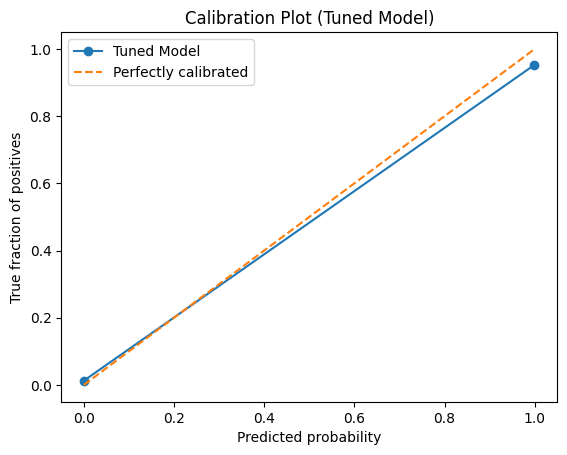

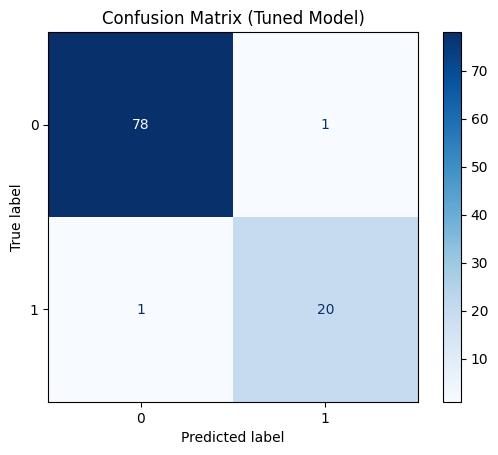

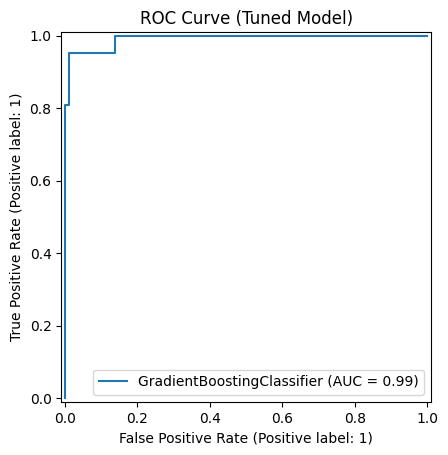

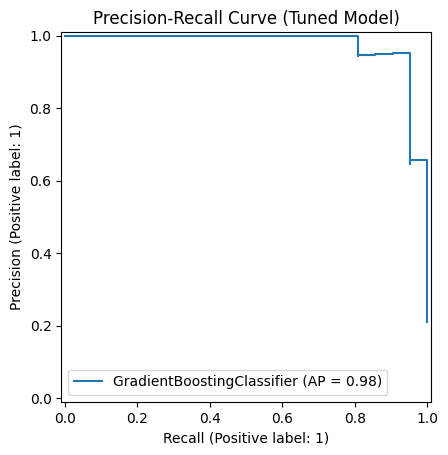

In [43]:
# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Tuned Model")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Calibration Plot (Tuned Model)")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test) # Use best_model
plt.title("ROC Curve (Tuned Model)")
plt.show()

# PR Curve
PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test) # Use best_model
plt.title("Precision-Recall Curve (Tuned Model)")
plt.show()

## 6. Explainability (SHAP)

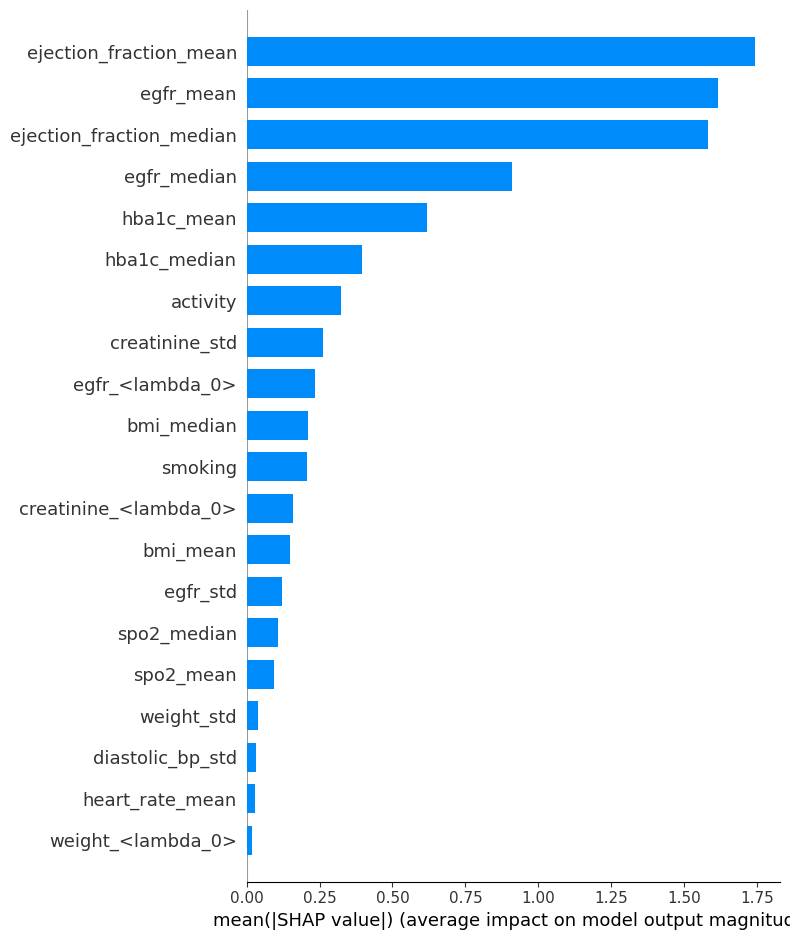

In [50]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Global feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=numeric_cols, plot_type="bar")

## 6. Cohort View

In [51]:
cohort_view = patients.loc[X_test.index].copy()
cohort_view["predicted_prob"] = y_prob
cohort_view["predicted_class"] = y_pred
cohort_view = cohort_view.sort_values("predicted_prob", ascending=False)

print("=== Cohort View: Top 10 highest risk patients ===")
display(cohort_view.head(10))


=== Cohort View: Top 10 highest risk patients ===


,patient_id,disease,age,gender,smoking,activity,sleep_hours,bmi,risk_label,predicted_prob,predicted_class
449,450,CKD,68,F,1,2,5.5,31.9,1,0.999999,1
236,237,CKD,32,F,1,7,5.8,29.0,1,0.999995,1
263,264,CKD,76,M,1,1,6.0,29.4,1,0.999983,1
103,104,CKD,37,F,0,0,6.0,32.2,1,0.999961,1
160,161,Heart Failure,79,M,0,6,5.8,13.6,1,0.999955,1
310,311,Heart Failure,78,M,0,7,5.6,33.9,1,0.999954,1
283,284,Heart Failure,41,M,0,7,7.5,29.6,1,0.999954,1
30,31,Heart Failure,74,F,0,8,5.3,23.0,1,0.999954,1
452,453,Heart Failure,70,F,0,4,5.6,31.9,1,0.999954,1
194,195,Heart Failure,60,F,0,9,8.1,23.2,1,0.999954,1


## 7. Patient Detail View

=== Patient Detail for patient_id=450 ===


,patient_id,disease,age,gender,smoking,activity,sleep_hours,bmi,risk_label,predicted_prob,predicted_class
449,450,CKD,68,F,1,2,5.5,31.9,1,0.999999,1


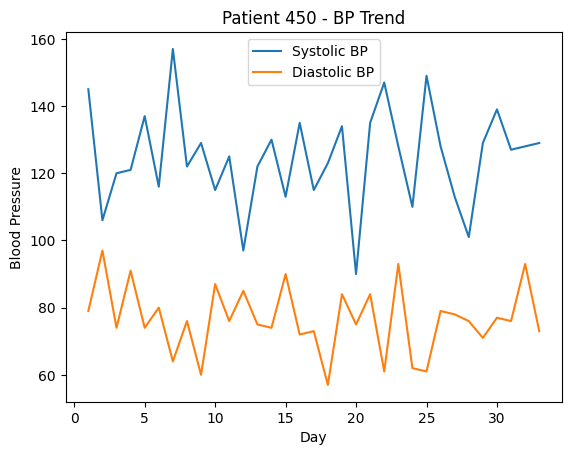

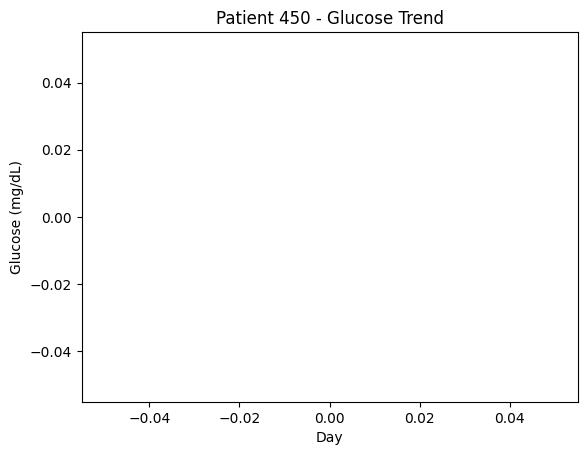

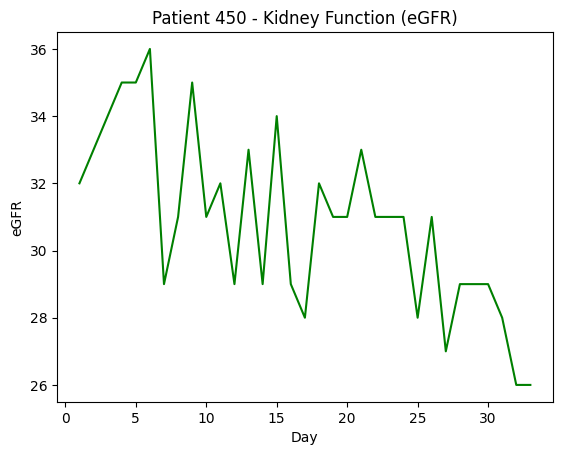

AttributeError: 'GradientBoostingClassifier' object has no attribute 'estimators_'

In [52]:
# 7. Patient Detail View

# Pick one patient (highest risk from cohort)
patient_id = cohort_view.iloc[0]["patient_id"]
print(f"=== Patient Detail for patient_id={patient_id} ===")

# Show patient-level record
patient_record = cohort_view.loc[cohort_view.patient_id==patient_id]
display(patient_record)

# Get patient timeseries
ts = timeseries[timeseries["patient_id"]==patient_id]

# Plot trends (example: BP, Glucose, eGFR, etc. if available)
if "systolic_bp" in ts.columns:
    plt.plot(ts["day"], ts["systolic_bp"], label="Systolic BP")
    plt.plot(ts["day"], ts["diastolic_bp"], label="Diastolic BP")
    plt.xlabel("Day"); plt.ylabel("Blood Pressure")
    plt.title(f"Patient {patient_id} - BP Trend")
    plt.legend(); plt.show()

if "glucose" in ts.columns:
    plt.plot(ts["day"], ts["glucose"], color="orange")
    plt.xlabel("Day"); plt.ylabel("Glucose (mg/dL)")
    plt.title(f"Patient {patient_id} - Glucose Trend")
    plt.show()

if "egfr" in ts.columns and ts["egfr"].notna().any():
    plt.plot(ts["day"], ts["egfr"], color="green")
    plt.xlabel("Day"); plt.ylabel("eGFR")
    plt.title(f"Patient {patient_id} - Kidney Function (eGFR)")
    plt.show()

# Explainability (SHAP)
explainer = shap.TreeExplainer(model)

# Pass unscaled DataFrame (X_test), SHAP handles it correctly
shap_values = explainer.shap_values(X_test)

# Find row index for patient
idx = list(X_test.index).index(patient_id)

# SHAP force plot (visual)
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test.iloc[idx],
    matplotlib=True
)


# ---- NEW: Text-based explanation ----
feature_importance = pd.Series(shap_values[idx], index=X_test.columns)
top_features = feature_importance.abs().sort_values(ascending=False).head(3)

explanation_parts = []
for feat in top_features.index:
    value = X_test.iloc[idx][feat]
    effect = feature_importance[feat]
    direction = "increased risk" if effect > 0 else "reduced risk"
    explanation_parts.append(f"{feat} (value={value:.2f}) → {direction}")

explanation_text = "Key drivers: " + "; ".join(explanation_parts)
print("\nClinician-Friendly Explanation:")
print(explanation_text)

# Rule-based suggestion (simple heuristic)
risk_score = patient_record["predicted_prob"].values[0]
if risk_score > 0.7:
    action = "Immediate follow-up and monitoring."
elif risk_score > 0.4:
    action = "Schedule closer check-up."
else:
    action = "Continue routine monitoring."
print("Recommended Action:", action)
